<a href="https://colab.research.google.com/github/lIlIlIIIlIIl/Toy_Project/blob/main/100_class_ResNet_Classification_visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os

#Dataset

In [ ]:
import zipfile

!mkdir results
!kaggle datasets download -d gpiosenka/sports-classification
zip_file = zipfile.ZipFile('/content/sports-classification.zip') # 압축을 해제할 '/파일경로/파일명.zip'
zip_file.extractall('/content/sports-classification') # 압축을 해제할 '/위치경로/'

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/sports-classification
License(s): CC0-1.0
 98% 417M/424M [00:11<00:00, 41.4MB/s]
100% 424M/424M [00:11<00:00, 40.2MB/s]


In [ ]:
# ===== transform 선언 ===== #
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# ===== 파일이 다운로드 된 경로 ===== #
data_folder = "/content/sports-classification"

train_folder = data_folder + "/train"
val_folder = data_folder + "/valid"
test_folder = data_folder + "/test"

trainset = datasets.ImageFolder(root=train_folder, transform=transform)
valset = datasets.ImageFolder(root=val_folder, transform=transform)
testset = datasets.ImageFolder(root=test_folder, transform=transform)

partition = {'train': trainset, 'val':valset, 'test':testset}


#ResNet

In [ ]:
resnet_weight = torchvision.models.ResNet50_Weights.DEFAULT

ResNet = torchvision.models.resnet50(weights = resnet_weight)

for param in ResNet.parameters():
    param.requires_grad = False

custom_fc = nn.Sequential(
    nn.ReLU(),
    nn.Dropout(p = 0.5),
    nn.Linear(1000, 100))

ResNet.fc = nn.Sequential(
    ResNet.fc,
    custom_fc
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 61.9MB/s]


# Train

In [ ]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다.

        # get the inputs
        inputs, labels = data
        # print(labels)
        # print(inputs.size()) # => (batchsize, channel, H, W) = (16, 3, 224, 224). 즉 dataloader가 4차원 텐서 형태로 데이터를 받아놓음; (shape쓰면 안됨)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

# Validation

In [ ]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

# Test

In [ ]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

# Experiment

In [ ]:
def experiment(partition, args):

    net = ResNet
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))


    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    return vars(args), result

#Visualize

In [ ]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)


def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

# Structure Info

In [ ]:
!pip install torchinfo
import torchinfo
from torchinfo import summary
from torchinfo import summary
summary(ResNet, input_size = (32, 3, 224, 224), col_names = ["output_size", "num_params", "trainable"], col_width = 15)


Layer (type:depth-idx)                   Output Shape    Param #         Trainable
ResNet                                   [32, 100]       --              Partial
├─Conv2d: 1-1                            [32, 64, 112, 112] (9,408)         False
├─BatchNorm2d: 1-2                       [32, 64, 112, 112] (128)           False
├─ReLU: 1-3                              [32, 64, 112, 112] --              --
├─MaxPool2d: 1-4                         [32, 64, 56, 56] --              --
├─Sequential: 1-5                        [32, 256, 56, 56] --              False
│    └─Bottleneck: 2-1                   [32, 256, 56, 56] --              False
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56] (4,096)         False
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56] (128)           False
│    │    └─ReLU: 3-3                    [32, 64, 56, 56] --              --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56] (36,864)        False
│    │    └─BatchNorm2d: 3-5         

# Execute

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1"

# ====== Model Capacity ====== #
args.out_dim = 100
args.hid_dim = 1000

# ====== Regularization ======= #
args.l2 = 0.001
args.use_bn = True
args.dropout = 0.5

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 20

args.train_batch_size = 32
args.test_batch_size = 32


print(args)

setting, result = experiment(partition, deepcopy(args))
save_exp_result(setting, result)


Namespace(exp_name='exp1', out_dim=100, hid_dim=1000, l2=0.001, use_bn=True, dropout=0.5, optim='Adam', lr=0.0001, epoch=20, train_batch_size=32, test_batch_size=32)
Epoch 0, Acc(train/val): 85.74/88.20, Loss(train/val) 0.71/0.60. Took 50.21 sec
Epoch 1, Acc(train/val): 85.67/88.20, Loss(train/val) 0.71/0.59. Took 49.81 sec
Epoch 2, Acc(train/val): 85.81/88.80, Loss(train/val) 0.71/0.57. Took 50.05 sec
Epoch 3, Acc(train/val): 85.55/88.20, Loss(train/val) 0.71/0.57. Took 49.61 sec
Epoch 4, Acc(train/val): 85.53/88.00, Loss(train/val) 0.70/0.54. Took 50.12 sec
Epoch 5, Acc(train/val): 85.90/87.40, Loss(train/val) 0.69/0.55. Took 49.87 sec
Epoch 6, Acc(train/val): 85.24/89.60, Loss(train/val) 0.70/0.55. Took 49.37 sec
Epoch 7, Acc(train/val): 84.95/87.80, Loss(train/val) 0.69/0.53. Took 50.40 sec
Epoch 8, Acc(train/val): 85.47/90.00, Loss(train/val) 0.68/0.52. Took 49.45 sec
Epoch 9, Acc(train/val): 85.70/88.40, Loss(train/val) 0.67/0.54. Took 50.44 sec
Epoch 10, Acc(train/val): 86.02/88

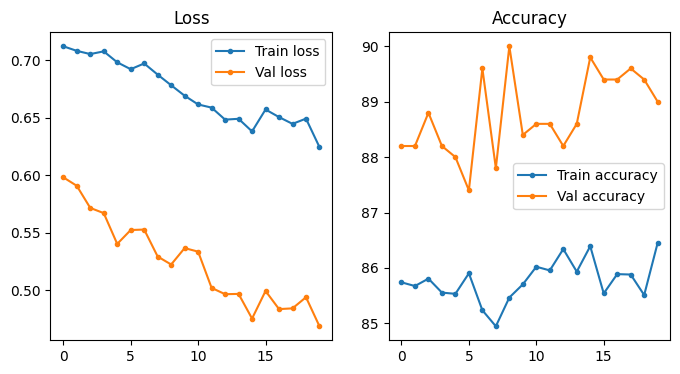

In [ ]:
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(result["train_losses"], label = "Train loss", marker='.')
plt.plot(result["val_losses"], label = "Val loss", marker='.')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(result["train_accs"], label = "Train accuracy", marker='.')
plt.plot(result["val_accs"], label = "Val accuracy", marker='.')
plt.legend()

In [ ]:
def eval(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=2)
    predict_label_list = []
    actual_label_list = []
    net.eval()
    for images, labels in testloader:

        for label in labels:
            label = label.item()
            actual_label_list.append(label)

        for image in images:
            with torch.inference_mode():
                image = image.cuda()
                # add batch_size and device
                image = image.unsqueeze(dim = 0)
                # logits
                logits = net(image)
                # lables
                label = torch.argmax(logits).item()
                predict_label_list.append(label)


    accuracy = accuracy_score(actual_label_list, predict_label_list)
    print(f"resnet_model's accuracy: {accuracy*100}%")

    # get class names
    class_names = []

    data_folder_path = "/content/sports-classification/test"

    for name in sorted(os.listdir(data_folder_path)):
        class_names.append(name)


    matrix = confusion_matrix(actual_label_list,
                            predict_label_list
                            )

    plt.figure(figsize = (18, 18))
    plt.imshow(matrix, interpolation= "nearest", cmap = "GnBu")

    ticks = range(len(class_names))
    plt.xticks(ticks, class_names, rotation= 45)
    plt.yticks(ticks, class_names)
    plt.show()

resnet_model's accuracy: 91.8%


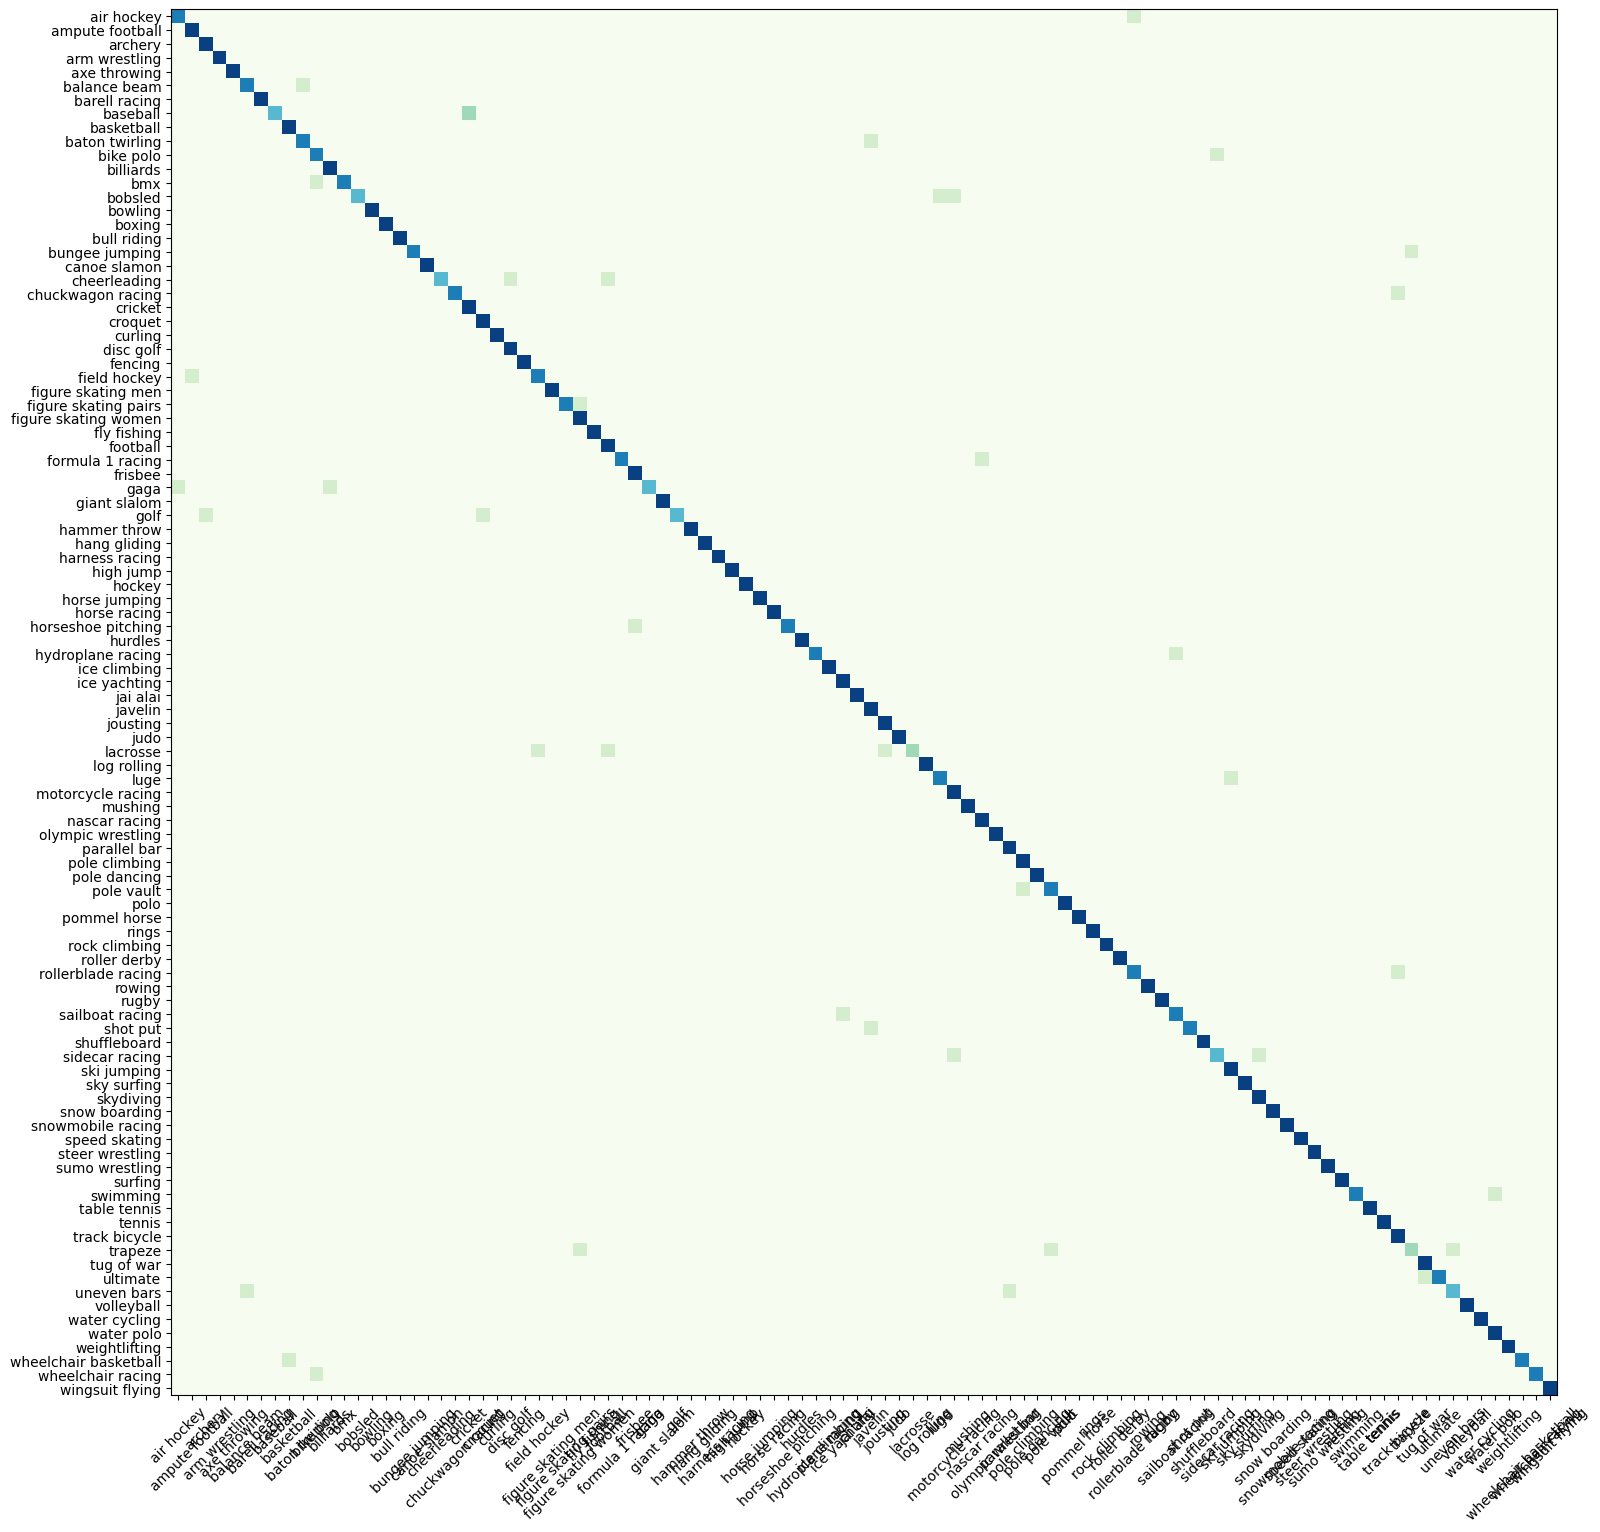

In [ ]:
eval(ResNet, partition, args)